In [1]:
# imports

from glob import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from os.path import join as osj
import tqdm
# %matplotlib inline 

In [2]:
# constants

max_skew = 10
scale_percent = 20 # percent of original size
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)

# samples

imgs = glob('*.jpg')

In [3]:
# functions

# read img in gray scale
def read_img(i):
    img = cv2.imread(i, 0)
    # height, width = img.shape
    return img

# change size of img
def compress_img(img):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return dim

# Hough filter and img processing - extract lines
def get_lines(img):
    try:
        height, width = img.shape
        # print(height, width)
        kernel = np.ones((10, 10), 'uint8')
        erode_img = cv2.erode(img, kernel, cv2.BORDER_REFLECT, iterations=1)
        im_bw = cv2.threshold(erode_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        lines = cv2.HoughLinesP(im_bw,1,np.pi/180, 200, minLineLength=width / 12, maxLineGap=width / 150)
        
    except Exception as er:
        print(er)
        pass
    return lines

# draw lines (gorizontal or vertical on images) - optional for single image
def draw_lines(lines, img):
    out = None
    try:
        for s in lines:
            x1,y1,x2,y2 = s[0]
            if abs(y1 - y2) <= 20: #filter gorizontal lines
                # print(s)
            # OR 
            # if abs(x1 - x2) <= 20: #filter vertical lines
                # print(s)
                line_img = cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2) #draw lines on images
                # plt.imsave('name.jpg', line_img)
                out = line_img
    except Exception as er:
        print(er)
        pass
    return out
    
# get only gorizontal
def filter_lines(lines):
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y1 - y2) <= 20: #filter gorizontal lines
            angles.append(np.arctan2(y2 - y1, x2 - x1))
    return angles

# average degree and deskew
def deskew(angles, img):
    angles = [angle for angle in angles if abs(angle) < np.deg2rad(max_skew)] #+/- 20 degrees angle
    height, width = img.shape
    # if len(angles) < 5:
        # with open(f'angles_log.log', 'a') as f:
        #     f.write(f'error with {im_path}: {}')
    # print(angles)
    
    # Average the angles to a degree offset
    angle_deg = np.rad2deg(np.median(angles))
    # print(angle_deg)
    
    # Rotate the image by the residual offset
    M = cv2.getRotationMatrix2D((width / 2, height / 2), angle_deg, 1)
    # print(M)
    im = cv2.warpAffine(img, M, (width, height), borderMode=cv2.BORDER_REPLICATE)
    # print(im)
    return im


In [9]:
# MAIN

# 1 - with open('letopisi_1959_1979_imgs_list.txt', 'r') as f:
    # img = f.read().split('\n')
    
for idx, i in enumerate((imgs)):
    print(i)
    img = read_img(i)
    dim = compress_img(img) #img shape - width and height
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) #compress image for preprocessing
    
    lines = get_lines(resized) #get all lines of text on images
    # print(lines)

    try:
    # OPTIONAL, for single sample image
        lines_on_img = draw_lines(lines, resized) #show lines (gorisontal or vertical with 20 degrees)
    except Exception as e:
        with open(f'errors_log_lines.log', 'a') as f:
            f.write(f'error with {i}: {e}')
    
    try:
        angles = filter_lines(lines) #save gorizontal lines only
        print(angles)
    except Exception as e:
        with open(f'errors_log_angles.log', 'a') as f:
            f.write(f'error with {i}: {e}')

    deskew_img = deskew(angles, img) #descew image with median of all gorizontal lines

    print(type(deskew_img)) #numpy array

    try:
        # OPTIONAL, save drawing lines
        plt.imsave(f'test_out/{i}', lines_on_img)
    except Exception as e:
        with open(f'errors_log_drawing.log', 'a') as f:
            f.write(f'error with {i}: {e}')

    try:
        # OPTIONAL, save deskew images
        cv2.imwrite(f'test_deskew/{i}', deskew_img)
    #     if idx % 10000 == 0:
    #         with open(f'deskewed_{idx}', 'w') as f:
    #             f.write('done')
    except Exception as e:
        with open(f'errors_log_deskew.log', 'a') as f:
            f.write(f'error with {i}: {e}')
            

0_0_img.jpg
[-0.035073330533225366, 0.0122693229537975, 0.0, -0.017542060057402487, 0.018955075491353144, 0.018516402068009044, -0.04925590198432362, -0.04891200614919467, 0.017855245139552514, -0.035383456124151315, -0.07304056530311932, 0.0, -0.07304056530311932, -0.014149998938006609, -0.055885801895600815, 0.018631384245264768, -0.01817981507297828, 0.023251622810462915, -0.05304752976147111, 0.012819810472900582, -0.015502633925016426, 0.014704822377851432, 0.0, 0.014850393379079521, -0.05123716740341881]
<class 'numpy.ndarray'>
0_img.jpg
'NoneType' object is not iterable
<class 'numpy.ndarray'>
1_1_img.jpg
[0.0, 0.017775905247621245, 0.0, 0.0, -0.03656905591354138, 0.017775905247621245, -0.017855245139552514, -0.018431092394098954, -0.03656905591354138, 0.0, 0.009615088299702515, -0.013887995930967074, 0.0, 0.0, 0.0, -0.036347621019020664, -0.03470827822527492, 0.0, 0.0, -0.03470827822527492, 0.05258306161094172, 0.0, 0.0, 0.034469100999508014, 0.0, 0.0, 0.0, 0.034469100999508014

c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0.01829064295682021, 0.0, 0.0668857248956666, -0.017542060057402487, 0.01829064295682021, 0.0, 0.03470827822527492, 0.018402830234312228, 0.06753001022495858, 0.017855245139552514, 0.017542060057402487, 0.08314123188844123, 0.03569911267932397, 0.0, 0.0, 0.03569911267932397, 0.0, -0.0447462314546156, 0.0688564893010446, 0.014491739065500022, 0.0]
<class 'numpy.ndarray'>
3_img.jpg
[]
<class 'numpy.ndarray'>
4_4_img.jpg
[-0.03470827822527492, -0.026660348374597954, -0.055116534294087326, -0.018402830234312228, -0.026660348374597954, -0.013332543294145677, 0.08749534080239131, -0.04964860638860627, -0.030665230926948613, -0.034469100999508014, -0.07030646411862446, 0.0, -0.034469100999508014, -0.06981641221234704, -0.06569480155246474, -0.017239671194529696, 0.0, -0.08758026649220838, -0.033885329904117606, -0.026660348374597954, -0.014704822377851432, 0.0, -0.05992815512120789, -0.07485984771076686, 0.0, -0.058755822715722696, -0.03569911267932397, -0.01694752980640491, 0.0]
<class 'num

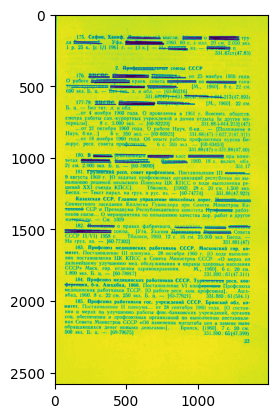

In [59]:
# EXAMPLES for testing

# img_lines = get_lines(sample)
# plt.imshow(line_img)

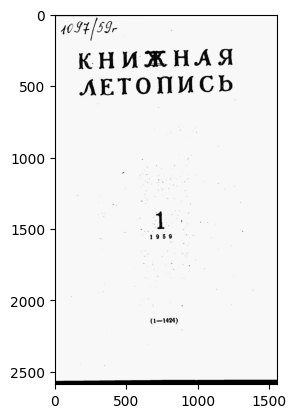

In [85]:
# rgb_img = cv2.cvtColor(line_img, cv2.COLOR_GRAY2RGB)
# plt.imshow(rgb_img)

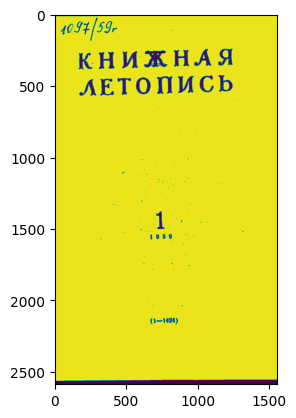

In [91]:
# img_lines = get_lines(sample)
# plt.imshow(line_img)

In [86]:
# plt.imsave('sample_title.jpg', rgb_img)